# Analyze Region 9 - Russian Arctic

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 9 - Russian Arctic.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "9"
region_name = "Russian Arctic"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # This was not already set in GLIMS so this is my guess at the classification

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 8
region_index_2 = 9

# Ice cap/icefield epsg code used for calculating area
#ic_epsg = '5940'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

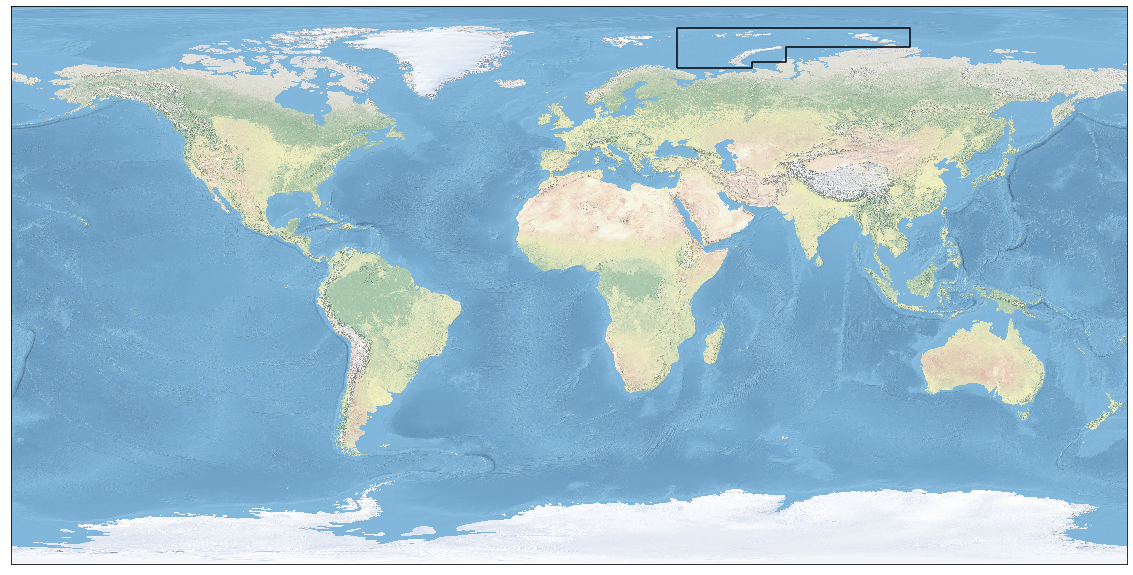

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
8,35.0,70.0,110.0,83.0


# * * * * * * * * Glacier Analysis * * * * * * * *

The glaciers are on Severny Island (large, banana shaped island) in Novaya Zemlya (archipelago northwest of Russia) and Komsomolets Island in Severnaya Zemlya (archipelago northeast of Russia)

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,9,G062382E75725N,1255.770,1256.770,0.0,0.0,0.0,6.0,583.0,909.0,2013-08-19T00:00:00,Severny Island Ice Cap (Severny Island),"POLYGON Z ((62.366901 75.914914 0, 62.369041 7..."
1,9,G094346E80731N,1243.330,1243.500,0.0,0.0,0.0,0.0,0.0,0.0,2006-07-13T00:00:00,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON Z ((97.133342 80.648343 0, 97.087396 8..."
2,9,G093532E80531N,1032.800,1032.800,0.0,0.0,0.0,0.0,0.0,0.0,2006-07-13T00:00:00,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON Z ((94.887281 80.58498899999999 0, 94...."
3,9,G059699E75391N,907.749,908.349,0.0,0.0,0.0,2.0,638.0,981.0,2013-08-03T00:00:00,Severny Island Ice Cap (Severny Island),"POLYGON Z ((60.711513 75.44164600000001 0, 60...."
4,9,G063849E75923N,840.852,841.507,0.0,0.0,0.0,1.0,532.0,877.0,2013-08-19T00:00:00,Severny Island Ice Cap (Severny Island),"POLYGON Z ((64.309765 76.07046699999999 0, 64...."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-09.00116,G060168E75349N,20000812,20080626,60.1675,75.3486,9,2,1412.730,43,...,133,55777,0,0,0,1,1,9,Vylki + Shury,"POLYGON ((60.25392142200008 75.57679367300005,..."
1,RGI60-09.00918,G095292E80735N,20020605,20100821,95.2917,80.7352,9,3,1243.510,18,...,7,26919,0,0,0,0,9,9,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON ((97.13334173000004 80.64834308600007,..."
2,RGI60-09.00969,G093532E80531N,20020605,20100821,93.5319,80.5308,9,3,1032.805,1,...,277,30137,0,0,0,1,9,9,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON ((94.88728057000009 80.58498948900007,..."
3,RGI60-09.00065,G062380E75725N,20000812,20080626,62.3796,75.7252,9,2,957.197,63,...,144,57101,0,0,1,1,1,9,Moshchnyy,"POLYGON ((62.44874871700006 75.89118618400005,..."
4,RGI60-09.00920,G096002E80452N,20020605,20100821,96.0020,80.4523,9,3,829.413,0,...,104,31780,0,0,1,1,9,9,Academy of Sciences Ice Cap (Komsomolets Island),"POLYGON ((97.05259920800006 80.52489718300006,..."


## Plot GLIMS Glaciers

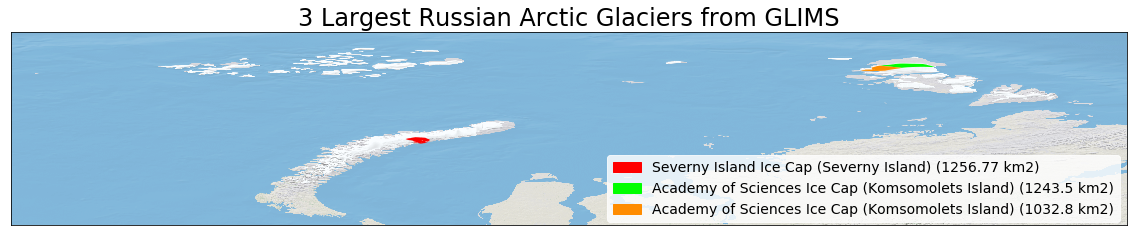

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

## Plot RGI Glaciers

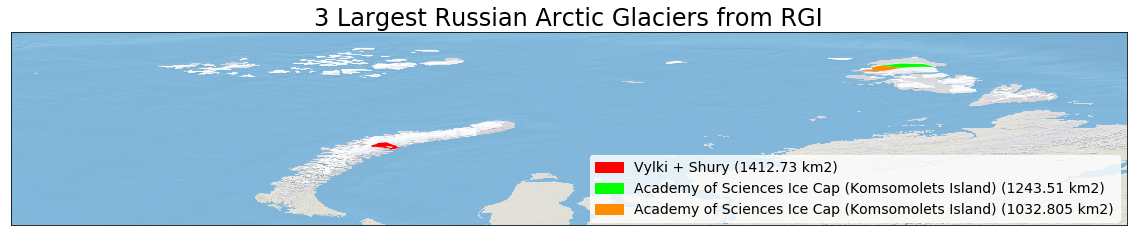

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

The names of glaciers in this region seem to be not well defined. From some literature, I've come up with the following possible glacier names

* G062382E75725N (Severny Island Ice Cap (Severny Island)) = Moshnyj Glacier (Carr, 2014)
* G094346E80731N (Academy of Sciences Ice Cap (Komsomolets Island)) = Academy of Sciences Ice Cap Basin North Glacier (Sánchez-Gámez, 2019)
* G093532E80531N (Academy of Sciences Ice Cap (Komsomolets Island) = Academy of Sciences Ice Cap Basin West Glacier (Sánchez-Gámez, 2019)

Note: Moshnyj Glacier in RGI is smaller than in GLIMS so it doesn't make the top 3 in RGI. The GLIMS one is the newest date so going with that.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

# Add RGI ID column
final_glacier_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], 
                                   rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_src,date,geometry
0,9,Russian Arctic,Severny Island Ice Cap (Severny Island),G062382E75725N,RGI60-09.00116,4,1256.77,-999,2013-08-19T00:00:00,"POLYGON Z ((62.366901 75.914914 0, 62.369041 7..."
1,9,Russian Arctic,Academy of Sciences Ice Cap (Komsomolets Island),G094346E80731N,RGI60-09.00918,4,1243.50,-999,2006-07-13T00:00:00,"POLYGON Z ((97.133342 80.648343 0, 97.087396 8..."
2,9,Russian Arctic,Academy of Sciences Ice Cap (Komsomolets Island),G093532E80531N,RGI60-09.00969,4,1032.80,-999,2006-07-13T00:00:00,"POLYGON Z ((94.887281 80.58498899999999 0, 94...."


In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    # The largest glacier in RGI doesn't match GLIMS and after a little research going to go with GLIMS,
    # so need to skip the first entry of GLIMS and RGI and just check the dates of the 2nd and 3rd largest
    if x == 0:
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
    else:    
        if glims_year == rgi_year:
            # Average GLIMS and RGI areas
            area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
            area_src = 'A'
            print('Averaging area: ' + str(area))
        elif glims_year > rgi_year:
            # Use GLIMS area for the area
            area = glims_glaciers_df['db_area'][x]
            area_src = 'G'
            print('Using GLIMS area: ' + str(area))
        elif rgi_year > glims_year:
            # Use RGI area for the area
            area = rgi_glaciers_df['Area'][x]
            area_src = 'R'
            print('Using RGI area: ' + str(area))
        else:
            print("Error. Area could not be calculated.")
    
    print('')
    # Set the area and area source in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
    # Use the glacier names from the literature for this region
    if x == 0:
        # Set this name per Carr (2014)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Moshnyj Glacier"
    if x == 1:
        # Set this name per Sánchez-Gámez (2019)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        "Academy of Sciences Ice Cap Basin North Glacier"
    if x == 2:
        # Set this name per Sánchez-Gámez (2019)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        "Academy of Sciences Ice Cap Basin West Glacier"

glims date: 20130819
rgi date: 20000812

glims date: 20060713
rgi date: 20020605
Using GLIMS area: 1243.5

glims date: 20060713
rgi date: 20020605
Using GLIMS area: 1032.8



In [19]:
# Find the centroid of the glacier and add the lat/lon to the dataframe
centroidseries_gl = final_glacier_data_df['geometry'].centroid
    
final_glacier_data_df['cenlat'] = [centroidseries_gl.geometry.y[0], centroidseries_gl.geometry.y[1], 
                                   centroidseries_gl.geometry.y[2]]
final_glacier_data_df['cenlon'] = [centroidseries_gl.geometry.x[0], centroidseries_gl.geometry.x[1], 
                                   centroidseries_gl.geometry.x[2]]

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                'primeclass', 'area_km2', 'area_src', 'date', 'cenlat', 'cenlon', 'geometry']]

In [20]:
# Because the RGI outlines are older and aren't being used, set the RGIID to N/A in the dataframe
final_glacier_data_df['rgi_id'] = 'N/A'

In [21]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_src,date,cenlat,cenlon,geometry
0,9,Russian Arctic,Moshnyj Glacier,G062382E75725N,N/A,4,1256.77,G,2013-08-19,75.730216,62.448051,"POLYGON Z ((62.366901 75.914914 0, 62.369041 7..."
1,9,Russian Arctic,Academy of Sciences Ice Cap Basin North Glacier,G094346E80731N,N/A,4,1243.50,G,2006-07-13,80.735207,95.291745,"POLYGON Z ((97.133342 80.648343 0, 97.087396 8..."
2,9,Russian Arctic,Academy of Sciences Ice Cap Basin West Glacier,G093532E80531N,N/A,4,1032.80,G,2006-07-13,80.530831,93.531900,"POLYGON Z ((94.887281 80.58498899999999 0, 94...."


### Plot final glacier dataframe to check accuracy

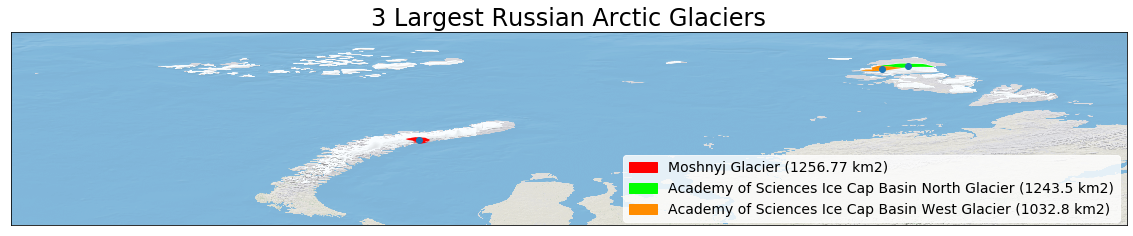

In [22]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)

# Plot the center points of the glacier complexes
centroidseries_gl.plot(ax=ax)

# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [38]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-9-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [24]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [25]:
ice_caps_ex_df

,id,area,geometry
0,90,20666.825170,"POLYGON ((56.918251 74.913927, 56.916186 74.91..."
1,1278,5573.536046,"POLYGON ((94.513183 80.150367, 94.504973000000..."
2,1017,4033.236356,"POLYGON ((99.511706 78.849071, 99.507997 78.84..."
3,977,2143.461514,"POLYGON ((105.083892 78.586887, 105.088035 78...."
4,84,1957.411483,"POLYGON ((47.815793 80.067213, 47.815661 80.06..."
5,1016,1781.421912,"POLYGON ((96.692133 79.13708, 96.676815 79.135..."
6,82,1746.044981,"POLYGON ((60.06830162498017 80.43894577225838,..."
7,88,1150.859872,"POLYGON ((63.311655 80.66166699999999, 63.3096..."
8,1103,1014.076580,"POLYGON ((97.80350300000001 79.90146799999999,..."
9,75,828.621568,"POLYGON ((57.960076 80.114254, 57.961116 80.11..."


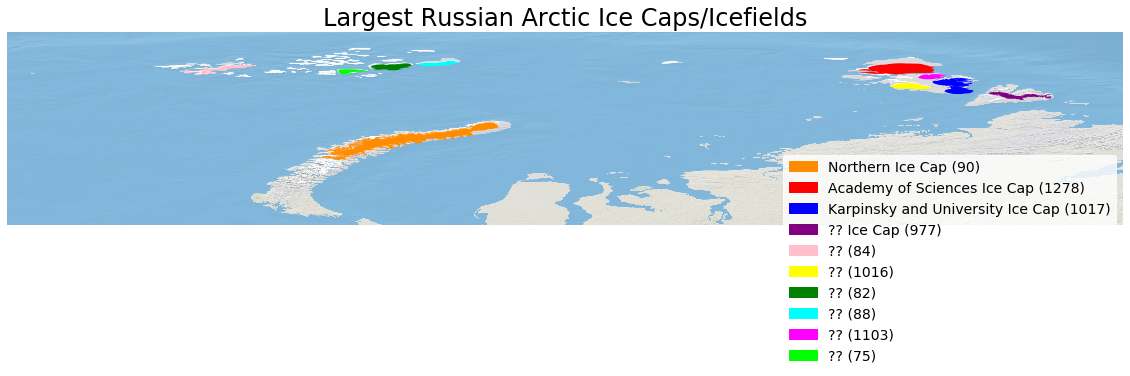

In [26]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Northern Ice Cap (90)', 'Academy of Sciences Ice Cap (1278)', 'Karpinsky and University Ice Cap (1017)', 
                 '?? Ice Cap (977)', '?? (84)', '?? (1016)', '?? (82)', 
                 '?? (88)', '?? (1103)', '?? (75)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.0, 0.4)) #, loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [27]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [3, 3, 3]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Severny Island Northern Ice Cap', 
                                      'Academy of Sciences Ice Cap', 
                                      'Karpinsky-University Glacier Complex']

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [28]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [29]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from shapefiles, set to 1 to run pip command

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True), buffer_val=.001)
    largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True), buffer_val=.001)
    largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
    largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-9-1st-largest-ic-glacier-outlines.shp
1st largest start date: 2002-02-08
1st largest end date: 2015-08-05

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-9-2nd-largest-ic-glacier-outlines.shp
2nd largest start date: 2006-07-13
2nd largest end date: 2006-07-13

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-9-3rd-largest-ic-glacier-outlines.shp
3rd largest start date: 2001-06-21
3rd largest end date: 2001-06-21



In [30]:
# Find the centroid of the glacier complex and add the lat/lon to the dataframe
centroidseries = final_catchment_data_df['geometry'].centroid

In [31]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add lat/lon
final_catchment_data_df['cenlat'] = [centroidseries.geometry.y[0], centroidseries.geometry.y[1], 
                                     centroidseries.geometry.y[2]]
final_catchment_data_df['cenlon'] = [centroidseries.geometry.x[0], centroidseries.geometry.x[1], 
                                     centroidseries.geometry.x[2]]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                   'min_date', 'max_date', 'cenlat', 'cenlon', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [32]:
final_catchment_data_df

,region_no,reg_name,ic_name,primeclass,area_km2,min_date,max_date,cenlat,cenlon,geometry
0,9,Russian Arctic,Severny Island Northern Ice Cap,3,20666.825170,2002-02-08,2015-08-05,75.680930,61.693105,"POLYGON ((56.918251 74.913927, 56.916186 74.91..."
1,9,Russian Arctic,Academy of Sciences Ice Cap,3,5573.536046,2006-07-13,2006-07-13,80.487734,94.992474,"POLYGON ((94.513183 80.150367, 94.504973000000..."
2,9,Russian Arctic,Karpinsky-University Glacier Complex,3,4033.236356,2001-06-21,2001-06-21,79.367445,98.722573,"POLYGON ((99.511706 78.849071, 99.507997 78.84..."


### Plot the final catchment dataframe to verify it looks correct

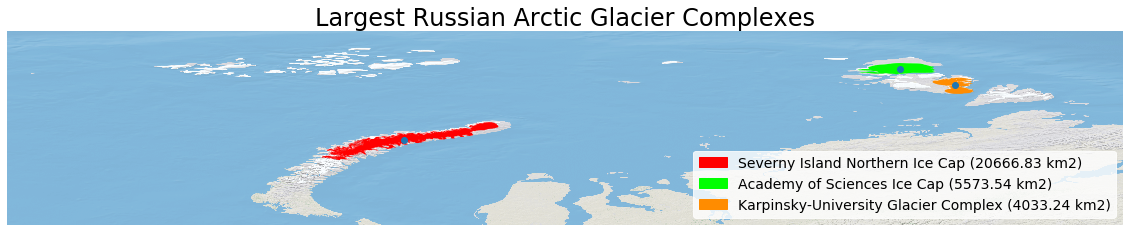

In [33]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Plot the center points of the glacier complexes
centroidseries.plot(ax=ax)

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         loc="lower right")

plt.show()

### Save final catchment dataframe to a shapefile

In [37]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-9-largest-complexes.zip


In [35]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

data/final-dataset/region-9-1st-largest-glims-ids.txt already extists
data/final-dataset/region-9-2nd-largest-glims-ids.txt already extists
data/final-dataset/region-9-3rd-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-9-1st-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-9-2nd-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-9-3rd-largest-ic-glacier-outlines.zip already extists


### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

The 1st largest ice catchment needed a buffer. A buffer value of .001 was optimal. The buffer value was added to the pip call in the code above.

In [36]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

Stopping notebook.


#### Check 1st largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['db_area'].sum()
if (abs(area_diff_1)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .001
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_1_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

#### Check 2nd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['db_area'].sum()
if (abs(area_diff_2)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    #acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_2_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax, color='blue')

#### Check 3rd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines 
# acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['db_area'].sum()
if (abs(area_diff_3)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_3_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax, color='blue')

## Clipping Ice Caps

Split up Karpinsky and University Ice Caps since they are touching (Sharov, 2009).

August 2021: Per review from my co-authors, have decided to not clip ice caps. I'm keeping this code for provenance. 

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

### Clip Karpinsky Ice Cap from University Ice Cap

In [ ]:
# Create a clipping polygon for Karpinsky Ice Cap
# Create dataframe that holds the clipping box
karp_area_points = Polygon([(100.5991, 79.9181), (99.0887, 79.9181),
                            (96.3089, 79.6414), (97.5284, 79.3001), 
                            (98.6435, 79.3367), (98.6984, 79.3001),
                            (100.5991, 79.2551), (100.5991, 79.9181)])

karp_gdf = gpd.GeoDataFrame([1],
                            geometry=[karp_area_points],
                            crs={'init': 'epsg:4326'})

karp_ex_ic_df = cl.clip_shp(ice_caps_ex_df.iloc[2:3], karp_gdf)

In [ ]:
karp_ex_ic_df

In [ ]:
# plot to take a look
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

minx = 95
maxx = 101
miny = 78
maxy = 80
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
karp_ex_ic_df.plot(ax=ax, color="darkorange")
karp_gdf.boundary.plot(ax=ax, color="purple")

In [ ]:
# Determine area of this clipped Karpinsky ice cap
crs_code = "+proj=laea"
karp_ex_area = karp_ex_ic_df['geometry'].to_crs(crs_code).area/10**6
round(karp_ex_area[2], 6)

In [ ]:
# Create a clipping polygon for University Ice Cap so we can clip it away from karpinsky
# Create dataframe that holds the clipping box
univ_area_points = Polygon([(97.5284, 79.3001), 
                            (98.6435, 79.3367), (98.6984, 79.3001),
                            (100.5991, 79.2551), (100.2612,78.7573), 
                            (97.4707,78.6991), (97.5284,79.3001)])

univ_gdf = gpd.GeoDataFrame([1],
                            geometry=[univ_area_points],
                            crs={'init': 'epsg:4326'})

univ_ex_ic_df = cl.clip_shp(ice_caps_ex_df.iloc[2:3], univ_gdf)

In [ ]:
univ_ex_ic_df

In [ ]:
# plot to take a look
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

minx = 95
maxx = 101
miny = 78
maxy = 80
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
univ_ex_ic_df.plot(ax=ax, color="darkorange")
univ_gdf.boundary.plot(ax=ax, color="purple")

In [ ]:
# Determine area of this clipped University ice cap
crs_code = "+proj=laea"
univ_ex_area = univ_ex_ic_df['geometry'].to_crs(crs_code).area/10**6
round(univ_ex_area[2], 6)

### Set up Ice Cap data frame

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_clipped_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 8 rows because only interested in the top 2 ice caps and icefields
final_clipped_catchment_data_df.drop([2, 3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add Karpinsky dataframe and update its area measurement
final_clipped_catchment_data_df = final_clipped_catchment_data_df.append(karp_ex_ic_df.drop(['id'], axis=1))
final_clipped_catchment_data_df.iloc[2, final_clipped_catchment_data_df.columns.get_loc('area')] = round(karp_ex_area[2], 6)

# Add region_no column
final_clipped_catchment_data_df['region_no'] = region_number

# Add region_name column
final_clipped_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_clipped_catchment_data_df['primeclass'] = [3, 3, 3]

# Add catchment names
final_clipped_catchment_data_df['ic_name'] = ['Severny Island Northern Ice Cap', 'Academy of Sciences Ice Cap', 
                                              'Karpinsky Ice Cap']

### Get ice catchment measurement dates from a range of glacier outline dates.

In [ ]:
# This section took about 1.5 hours to run so hard coding the info to variables and commenting out the code. 
# To rerun, uncomment the code
# Get glaciers on Northern Ice Cap
# ********** Uncomment out below to rerun ****************
#north_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
#north_glaciers = glims_all_glaciers_df.loc[north_ic_mask]
#north_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
#north_glaciers_min_date = north_glaciers['src_date'].min()[0:10]
#north_glaciers_max_date = north_glaciers['src_date'].max()[0:10]
# ************ Uncomment out above to rerun ***************
north_glaciers_min_date = '2004-07-19' # Comment this out to rerun
north_glaciers_max_date = '2015-08-05' # Comment this out to rerun
print('north start date: ' + north_glaciers_min_date)
print('north end date: ' + north_glaciers_max_date)
print('')

# Get all glims ids that make up the north ice catchment
# ********** Uncomment out below to rerun ****************
#nor_glims_ids = north_glaciers['glac_id']
#for i in range(len(nor_glims_ids)):
#    if i == 0:
#        all_nor_ids = nor_glims_ids[i]
#    else:
#        all_nor_ids = all_nor_ids + ', ' + nor_glims_ids[i]
# Read text file with the saved glims ids
# Comment out the 3 lines below to rerun
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-1st-largest-clipped-glims-ids.txt') as f:
    ids = f.readlines()
    all_nor_ids = ids[0]


# Get glaciers on Academy of Sciences Ice Cap
# ********** Uncomment out below to rerun ****************
#acad_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
#acad_glaciers = glims_all_glaciers_df.loc[acad_ic_mask]
#acad_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
#acad_glaciers_min_date = acad_glaciers['src_date'].min()[0:10]
#acad_glaciers_max_date = acad_glaciers['src_date'].max()[0:10]
# ************ Uncomment out above to rerun ***************
acad_glaciers_min_date = '2006-07-13' # Comment this out to rerun
acad_glaciers_max_date = '2006-07-13' # Comment this out to rerun
print('academy start date: ' + acad_glaciers_min_date)
print('academy end date: ' + acad_glaciers_max_date)
print('')

# Get all glims ids that make up the academy ice catchment
# ********** Uncomment out below to rerun ****************
#aca_glims_ids = acad_glaciers['glac_id']
#for i in range(len(aca_glims_ids)):
#    if i == 0:
#        all_aca_ids = aca_glims_ids[i]
#    else:
#        all_aca_ids = all_aca_ids + ', ' + aca_glims_ids[i]
# Read text file with the saved glims ids
# Comment out the 3 lines below to rerun
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-2nd-largest-clipped-glims-ids.txt') as f:
    ids = f.readlines()
    all_aca_ids = ids[0]

# Get glaciers on Karpinsky Ice Cap
# ********** Uncomment out below to rerun ****************
#karp_ic_mask = ws.pip(glims_all_glaciers_df, karp_ex_ic_df.iloc[0:1].reset_index(drop=True))
#karp_glaciers = glims_all_glaciers_df.loc[karp_ic_mask]
#karp_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
#karp_glaciers_min_date = karp_glaciers['src_date'].min()[0:10]
#karp_glaciers_max_date = karp_glaciers['src_date'].max()[0:10]
# ************ Uncomment out above to rerun ***************
karp_glaciers_min_date = '2001-06-21' # Comment this out to rerun
karp_glaciers_max_date = '2001-06-21' # Comment this out to rerun
print('karpinsky start date: ' + karp_glaciers_min_date)
print('karpinsky end date: ' + karp_glaciers_max_date)
print('')

# Get all glims ids that make up the karpinsky ice catchment
# ********** Uncomment out below to rerun ****************
#kar_glims_ids = karp_glaciers['glac_id']
#for i in range(len(kar_glims_ids)):
#    if i == 0:
#        all_kar_ids = kar_glims_ids[i]
#    else:
#        all_kar_ids = all_kar_ids + ', ' + kar_glims_ids[i]
# Read text file with the saved glims ids
# Comment out the 3 lines below to rerun
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-3rd-largest-clipped-glims-ids.txt') as f:
    ids = f.readlines()
    all_kar_ids = ids[0]

In [ ]:
# Add the dates to the dataframe
final_clipped_catchment_data_df['min_date'] = [north_glaciers_min_date, acad_glaciers_min_date, karp_glaciers_min_date]

final_clipped_catchment_data_df['max_date'] = [north_glaciers_max_date, acad_glaciers_max_date, karp_glaciers_max_date]

# Add the GLIMS IDS
final_clipped_catchment_data_df['glims_ids'] = [all_nor_ids, all_aca_ids, all_kar_ids]

# Reorder the columns
final_clipped_catchment_data_df = final_clipped_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                                 'min_date', 'max_date', 'glims_ids', 'geometry']]
# Rename the area column
final_clipped_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_clipped_catchment_data_df = final_clipped_catchment_data_df.reset_index(drop=True)

In [ ]:
final_clipped_catchment_data_df

### Plot the final catchment dataframe to verify it looks correct

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_clipped_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_clipped_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_clipped_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_clipped_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_clipped_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_clipped_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_clip_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes-clipped.zip"
if os.path.exists(catchment_clip_zipfile_fn) == False:
    # Create the shapefile
    final_clipped_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes-clipped.shp"
    final_clipped_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_clipped_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_clip_zipfile_fn = ws.zipshp(final_clipped_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_clip_zipfile_fn)
else:
    print(catchment_clip_zipfile_fn + " already extists")

In [ ]:
# Save the glims ids to a text file because it took a couple of hours to run the id selection code
text_file_1st_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-1st-largest-clipped-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_nor_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-2nd-largest-clipped-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_aca_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-3rd-largest-clipped-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_kar_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")

## Compute area of the clipped ice caps with an equal area projection

In [ ]:
# Open this regions clipped ice caps
ice_caps_clipped_fn = "data/final-dataset/old/region-9-largest-complexes-clipped/region-9-largest-complexes-clipped.shp"
ice_caps_clipped_df = gpd.read_file(ice_caps_clipped_fn)

In [ ]:
ice_caps_clipped_df

In [ ]:
crs_code = "+proj=laea"
academy_area = ice_caps_clipped_df.iloc[1:2]['geometry'].to_crs(crs_code).area/10**6
academy_area

In [ ]:
karpinsky_area = ice_caps_clipped_df.iloc[2:3]['geometry'].to_crs(crs_code).area/10**6
karpinsky_area